# Exercise 2

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model

import keras.layers as l
import keras.models as m
import keras.optimizers as o
import tensorflow as tf
from keras import backend as k



In [2]:
def predict(x, predictor):
    # Get the data from the test set
    # Get output of network and prediction
    activations = predictor.predict(x.reshape(1, 28, 28, 1))
    prediction = np.argmax(activations)
    # Print the prediction of the network
    print('Network output: ')
    print(activations)
    print('Network prediction: ')
    print(prediction)
    print('Actual image: ')
    # Draw the image
    plt.bar(range(10), activations[0])
    plt.show()
    plt.imshow(x.reshape((28, 28)), cmap='Greys')
    plt.show()


In [3]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalization in the dataset
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

11501568/11490434 [==============================] - 0s 0us/step


## Problem A

In [11]:
#  Stops training when the accuracy is greater than 99% in the validation set (avoids overfitting)
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("val_accuracy") >0.993):
            print("\nReached >99.3% accuracy so canceling training!")
            self.model.stop_training=True

callbacks = myCallback()

In [12]:
# Convolutional neural network
Input = l.Input(shape=(28, 28, 1))
#First Convolutional layer
hidden = l.Conv2D(32, (3,3), padding='same', activation="relu")(Input)
hidden = l.MaxPooling2D((2,2))(hidden)
#Second Convolutional layer
hidden = l.Conv2D(64, (3,3), padding='same', activation="relu")(hidden)
hidden = l.MaxPooling2D((2,2))(hidden)
#Third Convolutional layer
hidden = l.Conv2D(128, (3,3), padding='same', activation="relu")(hidden)
hidden = l.MaxPooling2D((2,2))(hidden)

hidden = l.Flatten()(hidden)
hidden = l.Dense(124, activation='relu')(hidden)


output = l.Dense(10, activation='softmax')(hidden)

classifier = m.Model(Input, output)


classifier.summary()
classifier.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),    
    metrics=["accuracy"]
)

classifier.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks = [callbacks]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         7385

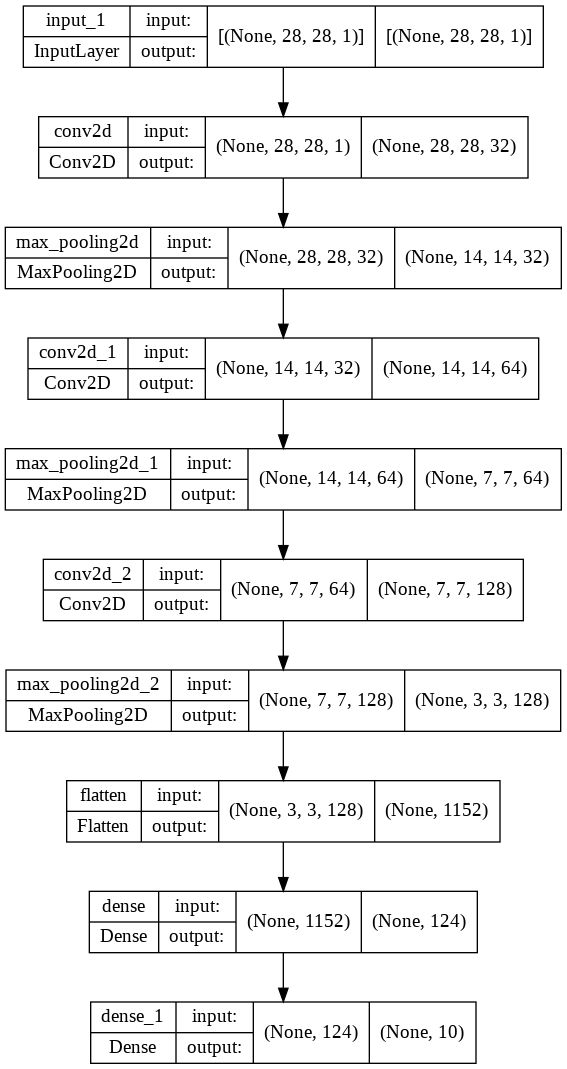

In [ ]:
dot_img_file = 'classifier.png'
tf.keras.utils.plot_model(classifier, to_file=dot_img_file, show_shapes=True)

## Problem B

In [13]:
def reCompile(classifier):
    classifier.trainable = False

    Input = l.Input(shape=(1,)) #Input neuron equal to 1
    hidden = l.Dense(256, activation="relu")(Input)
    hidden = l.Dense(28*28, activation="sigmoid")(hidden)
    output = l.Reshape((28, 28))(hidden) #Outputs a 28x28 grayscale image

    #Create adversarial model
    advModel = m.Model(Input, output)
    advModel.compile(
        loss='mean_squared_error',
        optimizer=tf.optimizers.Adam(learning_rate=0.01),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    #"Add" the classifier to the adversarial model
    wholeModel = m.Model(Input, classifier(output))
    wholeModel.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.Adam(learning_rate=0.009),
        metrics=["accuracy"]
    )

    return advModel, wholeModel


100%|██████████| 1000/1000 [00:13<00:00, 74.02it/s]


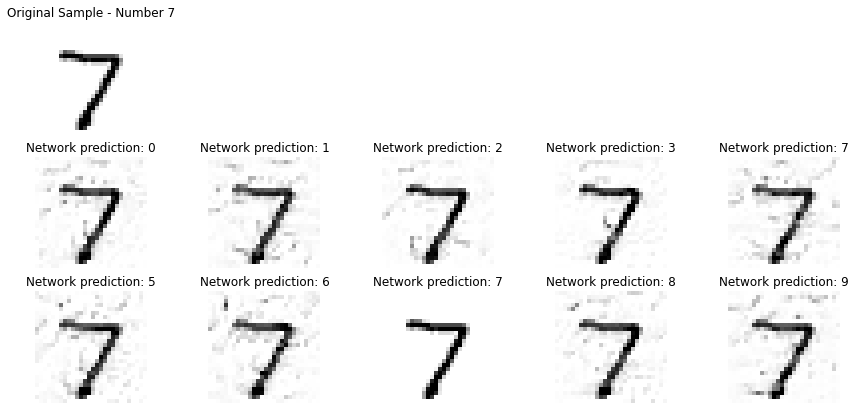

100%|██████████| 1000/1000 [00:13<00:00, 73.20it/s]


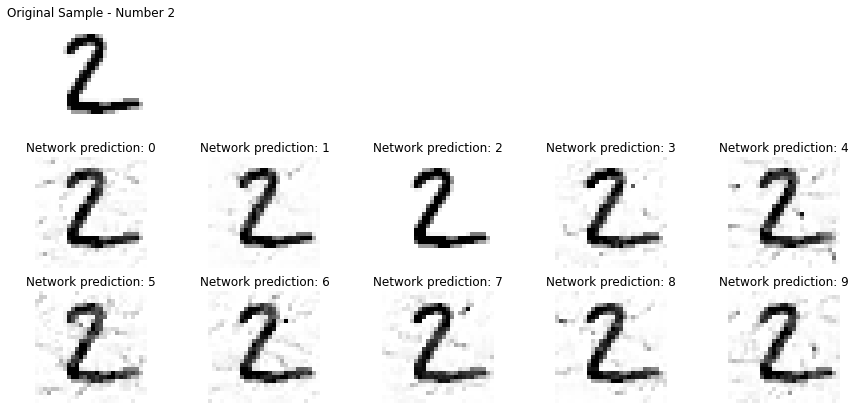

100%|██████████| 1000/1000 [00:13<00:00, 72.51it/s]


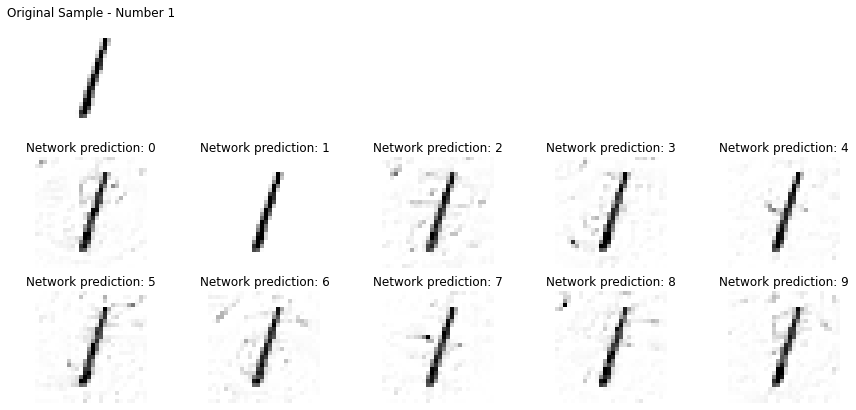

100%|██████████| 1000/1000 [00:13<00:00, 73.23it/s]


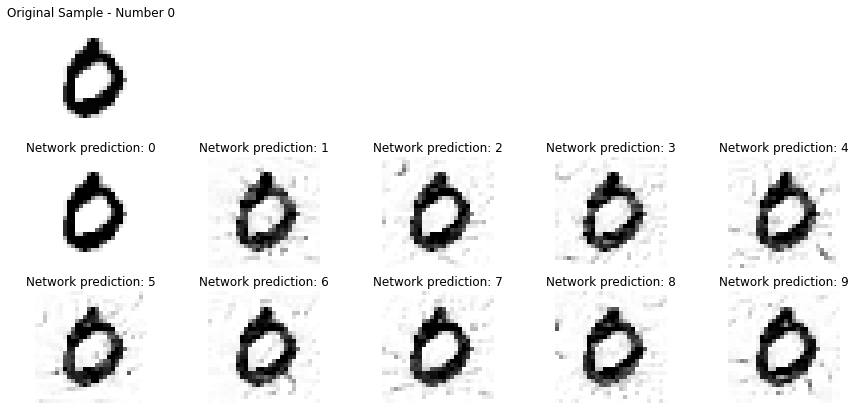

100%|██████████| 1000/1000 [00:13<00:00, 71.54it/s]


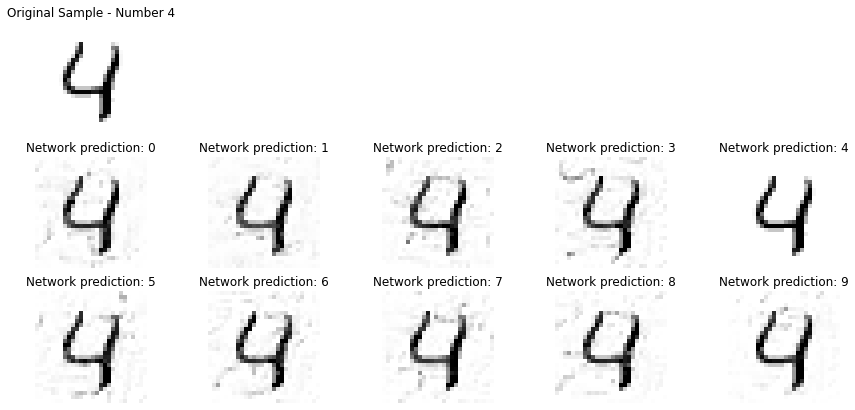

In [22]:
from tqdm import tqdm #progress meter


# Create adversarial examples of the first 5 samples of the test set and plot them on a grid
for i in range(5):
    x=x_test[i]
    y=np.argmax(y_test[i])

    max_figure = plt.figure(figsize=(15,7))
    rows = 3
    columns = 5

    max_figure.add_subplot(rows, columns, 1)
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    plt.axis('off')
    label = "Original Sample - Number " + str(y)
    plt.title(label)

    for one in range(10):
        advModel, wholeModel = reCompile(classifier)
        num = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        num[one] = 1

        for _ in tqdm(range(1000)):
            advModel.train_on_batch([np.array([1])], np.array([x])) # training of the adversarial model
            wholeModel.train_on_batch([np.array([1])], np.array([num,])) # training of the whole model
        advImage = advModel.predict([np.array([1])]).reshape(1, 28, 28, 1)
        activations = classifier(advImage.reshape(1, 28, 28, 1))
        prediction = np.argmax(activations)

        #Create image
        max_figure.add_subplot(rows, columns, one+6)
        label = "Network prediction: " + str(prediction)
        plt.imshow(advImage.reshape((28, 28)), cmap='Greys')
        plt.axis('off')

        #print(label)
        plt.title(label)


    plt.show()